# Setup

In [1]:
from __future__ import division, print_function

import numpy as np
from scipy.constants import c, e
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

### Beam

In [2]:
# INPUTS
n_mp = int(1e6)

dE = np.random.randn(n_mp) * 1e6 # [eV]
dt = np.random.randn(n_mp) * 1e-7 # [s]

gamma = 1.5

beta_x = 15
beta_y = 20
D_x = 2
epsn_x = 2e-6
epsn_y = 2e-6

In [3]:
# COMPUTED QUANTITIES
beta = np.sqrt(1 - gamma**-2)
dp = dE / (beta * c)
mu_x = np.random.randn(n_mp) * np.sqrt(epsn_x)
mu_y = np.random.randn(n_mp) * np.sqrt(epsn_y)

x = np.sqrt(beta_x) * mu_x + D_x * dp
y = np.sqrt(beta_y) * mu_y
z_beamframe = (-dt * beta * c) * gamma # Lorentz transformed

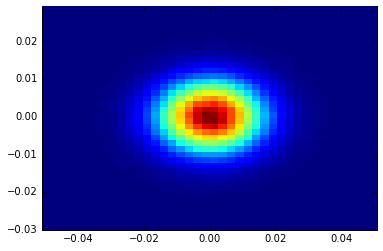

In [4]:
plt.hist2d(x, y, bins=40);

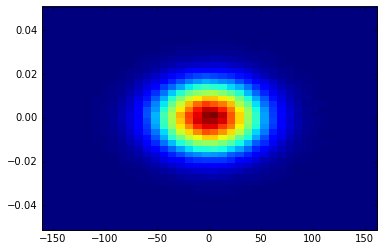

In [5]:
plt.hist2d(z_beamframe, x, bins=40);

### PyPIC Imports

In [6]:
# Import PyPIC, the particle-in-cell solver
# (to be found on github.com/PyCOMPLETE/PyPIC
# on the release/integrate-GPU branch as of 2.2.2017, 
# to be released to master branch at the end of February)
# don't forget to `make` before running here
import sys

sys.path.append('/home/oeftiger/cern/git/PyPIC') # path to the PyPIC directory

# modules inside the PyPIC/GPU directory:
from GPU.pypic import PyPIC_GPU
from GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver, GPUFFTPoissonSolver_2_5D
from GPU import meshing

PyKLU not found


### GPU Setup

In [7]:
# GPU set-up, requires pycuda package

arraylib = np
mathlib = np
from pycuda.autoinit import context
from pycuda import cumath
from pycuda import gpuarray as gp
arraylib = gp
mathlib = cumath

try:
    # ensure everything is on CPU host RAM
    x, y, z = x.get(), y.get(), z.get()
except AttributeError:
    pass

### Mesh

In [8]:
# nodes for the 3D mesh
n_x, n_y, n_z = 64, 64, 64
d_x, d_y, d_z = map(lambda ary, n: (np.max(ary) - np.min(ary)) / n, 
                    [x, y, z_beamframe], [n_x, n_y, n_z])

mesh = meshing.RectMesh3D(
    origin=map(np.min, [x, y, z_beamframe]),
    distances=[d_x, d_y, d_z],
    n_cells_per_direction=[n_x, n_y, n_z],
    mathlib=cumath
)

# Everything ready

### 3D field solving

In [9]:
solver = GPUFFTPoissonSolver(mesh, context=context)
# takes a mesh due to preallocation of memory (even though it's not soooo beautiful :D)

In [10]:
algorithm = PyPIC_GPU(mesh, solver, context)

In [11]:
# send arrays to GPU device RAM:
x, y, z_beamframe = map(gp.to_gpu, [x, y, z_beamframe])

In [12]:
%%timeit
# electric fields in the beam frame
global E_x, E_y, E_z
E_x, E_y, E_z = algorithm.pic_solve(x, y, z_beamframe, charge=e)

The slowest run took 20.19 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 118 ms per loop


In [13]:
# get arrays back to CPU host RAM:
x, y, z_beamframe = x.get(), y.get(), z_beamframe.get()
E_x, E_y, E_z = E_x.get(), E_y.get(), E_z.get()

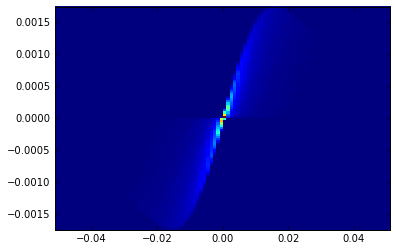

In [14]:
plt.hist2d(x, E_x, bins=100);

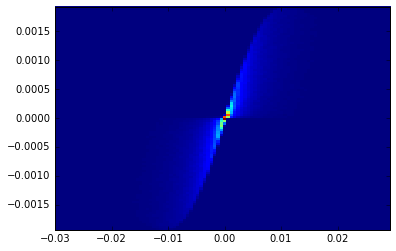

In [15]:
plt.hist2d(y, E_y, bins=100);

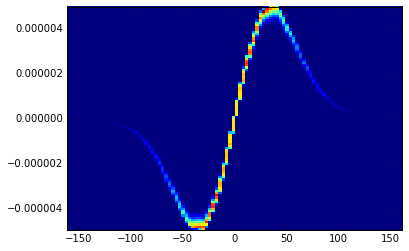

In [16]:
plt.hist2d(z_beamframe, E_z, bins=100);

### 2.5D field solving

Transverse solving along all slices defined by z direction of mesh:

In [17]:
solver25d = GPUFFTPoissonSolver_2_5D(mesh, context=context, save_memory=False)

In [18]:
algorithm25d = PyPIC_GPU(mesh, solver25d, context)

In [19]:
# send arrays to GPU device RAM:
x, y, z_beamframe = map(gp.to_gpu, [x, y, z_beamframe])

In [20]:
%%timeit
# electric fields in the beam frame
global E_x, E_y
E_x, E_y, _ = algorithm25d.pic_solve(x, y, z_beamframe, charge=e)

10 loops, best of 3: 115 ms per loop


In [21]:
# get arrays back to CPU host RAM:
x, y, z_beamframe = x.get(), y.get(), z_beamframe.get()
E_x, E_y = E_x.get(), E_y.get()

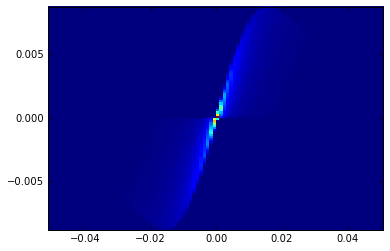

In [22]:
plt.hist2d(x, E_x, bins=100);

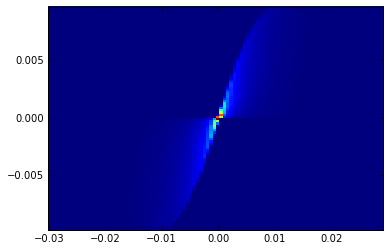

In [23]:
plt.hist2d(y, E_y, bins=100);

### Inspection

In [24]:
# send arrays to GPU device RAM:
x, y, z_beamframe = map(gp.to_gpu, [x, y, z_beamframe])

#### 3D case

In [25]:
%%timeit
global mesh_charges
mesh_charges = algorithm.particles_to_mesh(x, y, z_beamframe)

10 loops, best of 3: 58.1 ms per loop


In [26]:
%%timeit
global phi
phi = algorithm.poisson_solve(mesh_charges / mesh.volume_elem)

100 loops, best of 3: 9.1 ms per loop


In [27]:
%%timeit
global E_x_mesh, E_y_mesh, E_z_mesh
E_x_mesh, E_y_mesh, E_z_mesh = algorithm.get_electric_fields(phi)
context.synchronize()

1000 loops, best of 3: 779 µs per loop


In [28]:
%%timeit
global fields
fields = algorithm25d.field_to_particles(
    (E_x_mesh, x), (E_y_mesh, y), (E_z_mesh, z_beamframe)
)

10 loops, best of 3: 50.4 ms per loop


#### 2.5D case

In [29]:
%%timeit
global mesh_charges
mesh_charges = algorithm25d.particles_to_mesh(x, y, z_beamframe)

10 loops, best of 3: 58.8 ms per loop


In [30]:
%%timeit
global phi
phi = algorithm25d.poisson_solve(mesh_charges / (mesh.dx * mesh.dy))

100 loops, best of 3: 4.86 ms per loop


In [31]:
%%timeit
global E_x_mesh, E_y_mesh, dummy
E_x_mesh, E_y_mesh, dummy = algorithm25d.get_electric_fields(phi)
context.synchronize()

1000 loops, best of 3: 762 µs per loop


In [32]:
%%timeit
global fields
fields = algorithm25d.field_to_particles(
    (E_x_mesh, x), (E_y_mesh, y), (dummy, z_beamframe)
)

10 loops, best of 3: 51.8 ms per loop


#### done:

In [33]:
# get arrays back to CPU host RAM:
x, y, z_beamframe = x.get(), y.get(), z_beamframe.get()

.

.

.

.

.

.

.

.

.

.

# meshing

In [34]:
mesh.mathlib = np

In [35]:
%%timeit
mesh.get_weights(x, y, z_beamframe)

1 loop, best of 3: 214 ms per loop


In [36]:
mesh.mathlib = cumath

In [37]:
# send arrays to GPU device RAM:
x, y, z_beamframe = map(gp.to_gpu, [x, y, z_beamframe])

In [38]:
%%timeit
global weights
weights = mesh.get_weights(x, y, z_beamframe)

10 loops, best of 3: 37.5 ms per loop


In [39]:
from pycuda.elementwise import ElementwiseKernel

In [40]:
get_weights_new = ElementwiseKernel(
    # inputs:
    'double* x, double* y, double* z, '
    # outputs:
    'double* weight_ijk, double* weight_i1jk, '
    'double* weight_ij1k, double* weight_i1j1k, '
    'double* weight_ijk1, double* weight_i1jk1, '
    'double* weight_ij1k1, double* weight_i1j1k1',
    '''
    // indices
    double jj = floor((x[i] - {x0}) / {dx});
    double ii = floor((y[i] - {y0}) / {dy});
    double kk = floor((z[i] - {z0}) / {dz});
    
    // distances
    double dxi = x[i] - ({x0} + jj * {dx});
    double dyi = y[i] - ({y0} + ii * {dy});
    double dzi = z[i] - ({z0} + kk * {dz});
    
    // weights
    weight_ijk[i] =    (1.-dxi/{dx})*(1.-dyi/{dy})*(1.-dzi/{dz});
    weight_i1jk[i] =   (1.-dxi/{dx})*(dyi/{dy})   *(1.-dzi/{dz});
    weight_ij1k[i] =   (dxi/{dx})   *(1.-dyi/{dy})*(1.-dzi/{dz});
    weight_i1j1k[i] =  (dxi/{dx})   *(dyi/{dy})   *(1.-dzi/{dz});
    weight_ijk1[i] =   (1.-dxi/{dx})*(1.-dyi/{dy})*(dzi/{dz});
    weight_i1jk1[i] =  (1.-dxi/{dx})*(dyi/{dy})   *(dzi/{dz});
    weight_ij1k1[i] =  (dxi/{dx})   *(1.-dyi/{dy})*(dzi/{dz});
    weight_i1j1k1[i] = (dxi/{dx})   *(dyi/{dy})   *(dzi/{dz});
    '''.format(
        x0=mesh.x0, y0=mesh.y0, z0=mesh.z0, 
        dx=mesh.dx, dy=mesh.dy, dz=mesh.dz), 
    'get_weights'
)

In [41]:
(weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k,
weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1) = (
    gp.empty_like(x) for _ in range(8)
)

In [42]:
%%timeit -n 100
get_weights_new(
    # inputs:
    x, y, z_beamframe,
    # outputs:
    weight_ijk, weight_i1jk, weight_ij1k, weight_i1j1k,
    weight_ijk1, weight_i1jk1, weight_ij1k1, weight_i1j1k1
)
context.synchronize()

100 loops, best of 3: 1.12 ms per loop


In [43]:
np.allclose(weights[0].get(), weight_ijk.get(), atol=1e-4)

False

In [44]:
error = np.abs(weights[0].get() - weight_ijk.get())
error_ids = np.where(error > 1e-5)
print (error_ids, error[error_ids])

(array([  3698, 238281, 567910]),) [ 0.23006966  0.22079784  0.00201855]


In [45]:
# get arrays back to CPU host RAM:
x, y, z_beamframe = x.get(), y.get(), z_beamframe.get()